<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2023notebooks/2021_0618CAM_demo_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAM の実習

<div align='right'>
<a href='mailto:educ0233@komazawa-u.ac.jp'>Shin Aasakawa</a>, all rights reserved.<br>
Date: 24/Sep/2021<br/>
Appache 2.0 license<br/>
</div>

* 元論文: https://arxiv.org/abs/1512.04150


In [ ]:
try:
    import japanize_matplotlib
except ImportErrors:
    !pip install japanize_matplotlib
    import japanize_matplotlib

In [ ]:
# source: pytorchCAM.py
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb


# 使用する CNN モデルの名前を指定します。
# 以下の 3 つの中から選んでください。
# CAM はアベレージプーリング層を持つモデルに適用されます。
#model_name = 'squeezenet'
model_name = 'resnet'
#model_name = 'densenet'
if model_name == 'squeezenet':
    net = models.squeezenet1_1(weights='DEFAULT')
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_name == 'resnet':
    net = models.resnet18(weights='DEFAULT')
    finalconv_name = 'layer4'
elif model_name == 'densenet':
    net = models.densenet161(weights='DEFAULT')
    finalconv_name = 'features'

# ネットワーク構造を表示します。最終畳み込み層の名前に注目してください
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# PyTorch で中間層の出力結果を得るためには，register_hook 関数を使う必要があります
# 以下はそのための変数 `featre_blobs` を定義し，register_forward_hook 関数でその値を取り出す準備をしています。
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
# params[-1] が最終ソフトマックス層，params[-2] がソフトマックス層への重み係数
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    """CAM の実行
    最終直下層 feature_conv と最終層のソフトマックスとの係数とから
    CAM (クラス活性化マッピング) の値を計算して返す
    """
    size_upsample = (256, 256)  # CAM の アンサンプリグ地図 (256x256) を作成
    bz, nc, h, w = feature_conv.shape  # バッチサイズ，チャンネル数，高さ，幅の 4 次元テンソル
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [ ]:
# サンプル画像を読み込んで表示
import IPython
from PIL import Image as pil_img
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

# ImageNet の正解ラベル読み込み
LABELS_ja_URL= 'https://gist.githubusercontent.com/PonDad/4dcb4b242b9358e524b4ddecbee385e9/raw/dda9454f74aa4fafee991ca8b848c9ab6ae0e732/imagenet_class_index.json'
classes_ja = {int(i):val['ja'] for i, val in enumerate(requests.get(LABELS_ja_URL).json())}
# LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'


# 入力画像
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

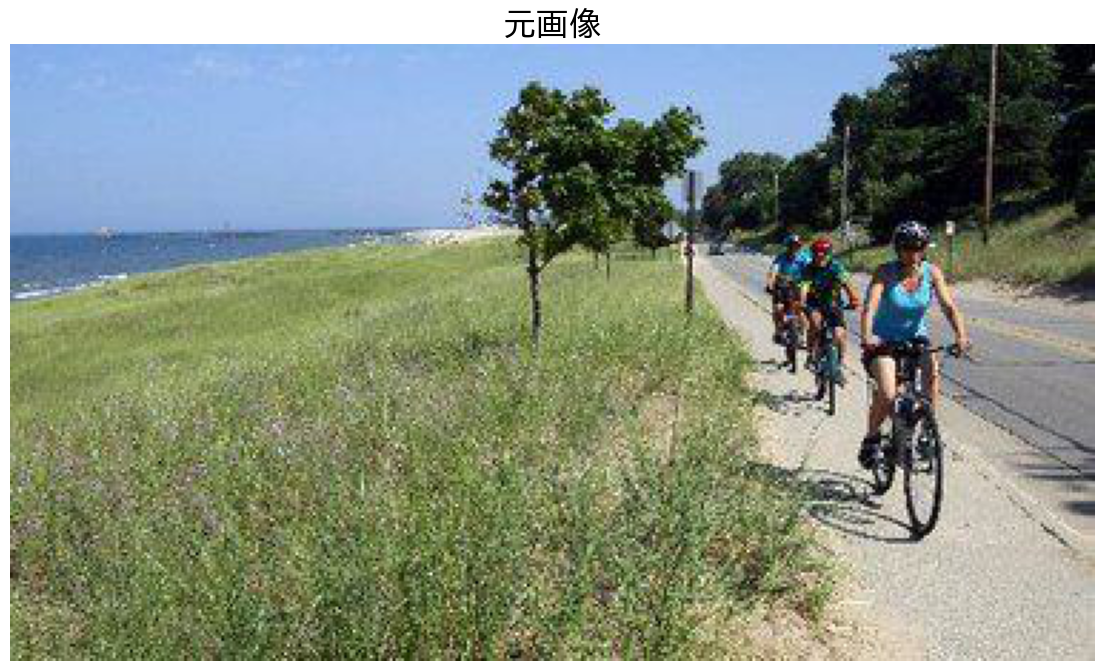

In [ ]:
import IPython
from PIL import Image as pil_img
import matplotlib.pyplot as plt

img = plt.imread('test.jpg')
plt.figure(figsize=(14,14))
plt.title('元画像', fontsize=24)
plt.axis('off')
plt.imshow(img)
# IPython.display.Image(url=IMG_URL) # IPython による画像の画面表示

img_pil = Image.open('test.jpg')


In [ ]:
# ImageNet のための画像認識モデルへの入力のため，画像のサイズと正規化の定義
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])


img_tensor = preprocess(img_pil) # 前処理
img_variable = Variable(img_tensor.unsqueeze(0))  # PyTorch の variable にする
logit = net(img_variable) # 認識実行。結果を logit に代入

h_x = F.softmax(logit, dim=1).data.squeeze() # ソフトマックス
probs, idx = h_x.sort(0, True) # 認識結果から，カテゴリの確率を得る
probs = probs.numpy()  # PyTorch から numpy 配列へ変換
idx = idx.numpy()

In [ ]:
#idx
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F

import sys
import numpy as np

# URL が変更になっているようなので，自前で解決するように変更した
# date: 2021-04-16
#import requests
#LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
#
# download the imagenet category list
#classes = {int(key):value for (key, value)
#          in requests.get(LABELS_URL).json().items()}
#classes ={i:labelmeta[x] for i, x in enumerate(labelmeta)}
labelmeta = {"n02119789": ["kit fox", "Vulpes macrotis"], "n02100735": ["English setter"], "n02110185": ["Siberian husky"], "n02096294": ["Australian terrier"], "n02102040": ["English springer", "English springer spaniel"], "n02066245": ["grey whale", "gray whale", "devilfish", "Eschrichtius gibbosus", "Eschrichtius robustus"], "n02509815": ["lesser panda", "red panda", "panda", "bear cat", "cat bear", "Ailurus fulgens"], "n02124075": ["Egyptian cat"], "n02417914": ["ibex", "Capra ibex"], "n02123394": ["Persian cat"], "n02125311": ["cougar", "puma", "catamount", "mountain lion", "painter", "panther", "Felis concolor"], "n02423022": ["gazelle"], "n02346627": ["porcupine", "hedgehog"], "n02077923": ["sea lion"], "n02110063": ["malamute", "malemute", "Alaskan malamute"], "n02447366": ["badger"], "n02109047": ["Great Dane"], "n02089867": ["Walker hound", "Walker foxhound"], "n02102177": ["Welsh springer spaniel"], "n02091134": ["whippet"], "n02092002": ["Scottish deerhound", "deerhound"], "n02071294": ["killer whale", "killer", "orca", "grampus", "sea wolf", "Orcinus orca"], "n02442845": ["mink"], "n02504458": ["African elephant", "Loxodonta africana"], "n02092339": ["Weimaraner"], "n02098105": ["soft-coated wheaten terrier"], "n02096437": ["Dandie Dinmont", "Dandie Dinmont terrier"], "n02114712": ["red wolf", "maned wolf", "Canis rufus", "Canis niger"], "n02105641": ["Old English sheepdog", "bobtail"], "n02128925": ["jaguar", "panther", "Panthera onca", "Felis onca"], "n02091635": ["otterhound", "otter hound"], "n02088466": ["bloodhound", "sleuthhound"], "n02096051": ["Airedale", "Airedale terrier"], "n02117135": ["hyena", "hyaena"], "n02138441": ["meerkat", "mierkat"], "n02097130": ["giant schnauzer"], "n02493509": ["titi", "titi monkey"], "n02457408": ["three-toed sloth", "ai", "Bradypus tridactylus"], "n02389026": ["sorrel"], "n02443484": ["black-footed ferret", "ferret", "Mustela nigripes"], "n02110341": ["dalmatian", "coach dog", "carriage dog"], "n02089078": ["black-and-tan coonhound"], "n02086910": ["papillon"], "n02445715": ["skunk", "polecat", "wood pussy"], "n02093256": ["Staffordshire bullterrier", "Staffordshire bull terrier"], "n02113978": ["Mexican hairless"], "n02106382": ["Bouvier des Flandres", "Bouviers des Flandres"], "n02441942": ["weasel"], "n02113712": ["miniature poodle"], "n02113186": ["Cardigan", "Cardigan Welsh corgi"], "n02105162": ["malinois"], "n02415577": ["bighorn", "bighorn sheep", "cimarron", "Rocky Mountain bighorn", "Rocky Mountain sheep", "Ovis canadensis"], "n02356798": ["fox squirrel", "eastern fox squirrel", "Sciurus niger"], "n02488702": ["colobus", "colobus monkey"], "n02123159": ["tiger cat"], "n02098413": ["Lhasa", "Lhasa apso"], "n02422699": ["impala", "Aepyceros melampus"], "n02114855": ["coyote", "prairie wolf", "brush wolf", "Canis latrans"], "n02094433": ["Yorkshire terrier"], "n02111277": ["Newfoundland", "Newfoundland dog"], "n02132136": ["brown bear", "bruin", "Ursus arctos"], "n02119022": ["red fox", "Vulpes vulpes"], "n02091467": ["Norwegian elkhound", "elkhound"], "n02106550": ["Rottweiler"], "n02422106": ["hartebeest"], "n02091831": ["Saluki", "gazelle hound"], "n02120505": ["grey fox", "gray fox", "Urocyon cinereoargenteus"], "n02104365": ["schipperke"], "n02086079": ["Pekinese", "Pekingese", "Peke"], "n02112706": ["Brabancon griffon"], "n02098286": ["West Highland white terrier"], "n02095889": ["Sealyham terrier", "Sealyham"], "n02484975": ["guenon", "guenon monkey"], "n02137549": ["mongoose"], "n02500267": ["indri", "indris", "Indri indri", "Indri brevicaudatus"], "n02129604": ["tiger", "Panthera tigris"], "n02090721": ["Irish wolfhound"], "n02396427": ["wild boar", "boar", "Sus scrofa"], "n02108000": ["EntleBucher"], "n02391049": ["zebra"], "n02412080": ["ram", "tup"], "n02108915": ["French bulldog"], "n02480495": ["orangutan", "orang", "orangutang", "Pongo pygmaeus"], "n02110806": ["basenji"], "n02128385": ["leopard", "Panthera pardus"], "n02107683": ["Bernese mountain dog"], "n02085936": ["Maltese dog", "Maltese terrier", "Maltese"], "n02094114": ["Norfolk terrier"], "n02087046": ["toy terrier"], "n02100583": ["vizsla", "Hungarian pointer"], "n02096177": ["cairn", "cairn terrier"], "n02494079": ["squirrel monkey", "Saimiri sciureus"], "n02105056": ["groenendael"], "n02101556": ["clumber", "clumber spaniel"], "n02123597": ["Siamese cat", "Siamese"], "n02481823": ["chimpanzee", "chimp", "Pan troglodytes"], "n02105505": ["komondor"], "n02088094": ["Afghan hound", "Afghan"], "n02085782": ["Japanese spaniel"], "n02489166": ["proboscis monkey", "Nasalis larvatus"], "n02364673": ["guinea pig", "Cavia cobaya"], "n02114548": ["white wolf", "Arctic wolf", "Canis lupus tundrarum"], "n02134084": ["ice bear", "polar bear", "Ursus Maritimus", "Thalarctos maritimus"], "n02480855": ["gorilla", "Gorilla gorilla"], "n02090622": ["borzoi", "Russian wolfhound"], "n02113624": ["toy poodle"], "n02093859": ["Kerry blue terrier"], "n02403003": ["ox"], "n02097298": ["Scotch terrier", "Scottish terrier", "Scottie"], "n02108551": ["Tibetan mastiff"], "n02493793": ["spider monkey", "Ateles geoffroyi"], "n02107142": ["Doberman", "Doberman pinscher"], "n02096585": ["Boston bull", "Boston terrier"], "n02107574": ["Greater Swiss Mountain dog"], "n02107908": ["Appenzeller"], "n02086240": ["Shih-Tzu"], "n02102973": ["Irish water spaniel"], "n02112018": ["Pomeranian"], "n02093647": ["Bedlington terrier"], "n02397096": ["warthog"], "n02437312": ["Arabian camel", "dromedary", "Camelus dromedarius"], "n02483708": ["siamang", "Hylobates syndactylus", "Symphalangus syndactylus"], "n02097047": ["miniature schnauzer"], "n02106030": ["collie"], "n02099601": ["golden retriever"], "n02093991": ["Irish terrier"], "n02110627": ["affenpinscher", "monkey pinscher", "monkey dog"], "n02106166": ["Border collie"], "n02326432": ["hare"], "n02108089": ["boxer"], "n02097658": ["silky terrier", "Sydney silky"], "n02088364": ["beagle"], "n02111129": ["Leonberg"], "n02100236": ["German short-haired pointer"], "n02486261": ["patas", "hussar monkey", "Erythrocebus patas"], "n02115913": ["dhole", "Cuon alpinus"], "n02486410": ["baboon"], "n02487347": ["macaque"], "n02099849": ["Chesapeake Bay retriever"], "n02108422": ["bull mastiff"], "n02104029": ["kuvasz"], "n02492035": ["capuchin", "ringtail", "Cebus capucinus"], "n02110958": ["pug", "pug-dog"], "n02099429": ["curly-coated retriever"], "n02094258": ["Norwich terrier"], "n02099267": ["flat-coated retriever"], "n02395406": ["hog", "pig", "grunter", "squealer", "Sus scrofa"], "n02112350": ["keeshond"], "n02109961": ["Eskimo dog", "husky"], "n02101388": ["Brittany spaniel"], "n02113799": ["standard poodle"], "n02095570": ["Lakeland terrier"], "n02128757": ["snow leopard", "ounce", "Panthera uncia"], "n02101006": ["Gordon setter"], "n02115641": ["dingo", "warrigal", "warragal", "Canis dingo"], "n02097209": ["standard schnauzer"], "n02342885": ["hamster"], "n02097474": ["Tibetan terrier", "chrysanthemum dog"], "n02120079": ["Arctic fox", "white fox", "Alopex lagopus"], "n02095314": ["wire-haired fox terrier"], "n02088238": ["basset", "basset hound"], "n02408429": ["water buffalo", "water ox", "Asiatic buffalo", "Bubalus bubalis"], "n02133161": ["American black bear", "black bear", "Ursus americanus", "Euarctos americanus"], "n02328150": ["Angora", "Angora rabbit"], "n02410509": ["bison"], "n02492660": ["howler monkey", "howler"], "n02398521": ["hippopotamus", "hippo", "river horse", "Hippopotamus amphibius"], "n02112137": ["chow", "chow chow"], "n02510455": ["giant panda", "panda", "panda bear", "coon bear", "Ailuropoda melanoleuca"], "n02093428": ["American Staffordshire terrier", "Staffordshire terrier", "American pit bull terrier", "pit bull terrier"], "n02105855": ["Shetland sheepdog", "Shetland sheep dog", "Shetland"], "n02111500": ["Great Pyrenees"], "n02085620": ["Chihuahua"], "n02123045": ["tabby", "tabby cat"], "n02490219": ["marmoset"], "n02099712": ["Labrador retriever"], "n02109525": ["Saint Bernard", "St Bernard"], "n02454379": ["armadillo"], "n02111889": ["Samoyed", "Samoyede"], "n02088632": ["bluetick"], "n02090379": ["redbone"], "n02443114": ["polecat", "fitch", "foulmart", "foumart", "Mustela putorius"], "n02361337": ["marmot"], "n02105412": ["kelpie"], "n02483362": ["gibbon", "Hylobates lar"], "n02437616": ["llama"], "n02107312": ["miniature pinscher"], "n02325366": ["wood rabbit", "cottontail", "cottontail rabbit"], "n02091032": ["Italian greyhound"], "n02129165": ["lion", "king of beasts", "Panthera leo"], "n02102318": ["cocker spaniel", "English cocker spaniel", "cocker"], "n02100877": ["Irish setter", "red setter"], "n02074367": ["dugong", "Dugong dugon"], "n02504013": ["Indian elephant", "Elephas maximus"], "n02363005": ["beaver"], "n02102480": ["Sussex spaniel"], "n02113023": ["Pembroke", "Pembroke Welsh corgi"], "n02086646": ["Blenheim spaniel"], "n02497673": ["Madagascar cat", "ring-tailed lemur", "Lemur catta"], "n02087394": ["Rhodesian ridgeback"], "n02127052": ["lynx", "catamount"], "n02116738": ["African hunting dog", "hyena dog", "Cape hunting dog", "Lycaon pictus"], "n02488291": ["langur"], "n02091244": ["Ibizan hound", "Ibizan Podenco"], "n02114367": ["timber wolf", "grey wolf", "gray wolf", "Canis lupus"], "n02130308": ["cheetah", "chetah", "Acinonyx jubatus"], "n02089973": ["English foxhound"], "n02105251": ["briard"], "n02134418": ["sloth bear", "Melursus ursinus", "Ursus ursinus"], "n02093754": ["Border terrier"], "n02106662": ["German shepherd", "German shepherd dog", "German police dog", "alsatian"], "n02444819": ["otter"], "n01882714": ["koala", "koala bear", "kangaroo bear", "native bear", "Phascolarctos cinereus"], "n01871265": ["tusker"], "n01872401": ["echidna", "spiny anteater", "anteater"], "n01877812": ["wallaby", "brush kangaroo"], "n01873310": ["platypus", "duckbill", "duckbilled platypus", "duck-billed platypus", "Ornithorhynchus anatinus"], "n01883070": ["wombat"], "n04086273": ["revolver", "six-gun", "six-shooter"], "n04507155": ["umbrella"], "n04147183": ["schooner"], "n04254680": ["soccer ball"], "n02672831": ["accordion", "piano accordion", "squeeze box"], "n02219486": ["ant", "emmet", "pismire"], "n02317335": ["starfish", "sea star"], "n01968897": ["chambered nautilus", "pearly nautilus", "nautilus"], "n03452741": ["grand piano", "grand"], "n03642806": ["laptop", "laptop computer"], "n07745940": ["strawberry"], "n02690373": ["airliner"], "n04552348": ["warplane", "military plane"], "n02692877": ["airship", "dirigible"], "n02782093": ["balloon"], "n04266014": ["space shuttle"], "n03344393": ["fireboat"], "n03447447": ["gondola"], "n04273569": ["speedboat"], "n03662601": ["lifeboat"], "n02951358": ["canoe"], "n04612504": ["yawl"], "n02981792": ["catamaran"], "n04483307": ["trimaran"], "n03095699": ["container ship", "containership", "container vessel"], "n03673027": ["liner", "ocean liner"], "n03947888": ["pirate", "pirate ship"], "n02687172": ["aircraft carrier", "carrier", "flattop", "attack aircraft carrier"], "n04347754": ["submarine", "pigboat", "sub", "U-boat"], "n04606251": ["wreck"], "n03478589": ["half track"], "n04389033": ["tank", "army tank", "armored combat vehicle", "armoured combat vehicle"], "n03773504": ["missile"], "n02860847": ["bobsled", "bobsleigh", "bob"], "n03218198": ["dogsled", "dog sled", "dog sleigh"], "n02835271": ["bicycle-built-for-two", "tandem bicycle", "tandem"], "n03792782": ["mountain bike", "all-terrain bike", "off-roader"], "n03393912": ["freight car"], "n03895866": ["passenger car", "coach", "carriage"], "n02797295": ["barrow", "garden cart", "lawn cart", "wheelbarrow"], "n04204347": ["shopping cart"], "n03791053": ["motor scooter", "scooter"], "n03384352": ["forklift"], "n03272562": ["electric locomotive"], "n04310018": ["steam locomotive"], "n02704792": ["amphibian", "amphibious vehicle"], "n02701002": ["ambulance"], "n02814533": ["beach wagon", "station wagon", "wagon", "estate car", "beach waggon", "station waggon", "waggon"], "n02930766": ["cab", "hack", "taxi", "taxicab"], "n03100240": ["convertible"], "n03594945": ["jeep", "landrover"], "n03670208": ["limousine", "limo"], "n03770679": ["minivan"], "n03777568": ["Model T"], "n04037443": ["racer", "race car", "racing car"], "n04285008": ["sports car", "sport car"], "n03444034": ["go-kart"], "n03445924": ["golfcart", "golf cart"], "n03785016": ["moped"], "n04252225": ["snowplow", "snowplough"], "n03345487": ["fire engine", "fire truck"], "n03417042": ["garbage truck", "dustcart"], "n03930630": ["pickup", "pickup truck"], "n04461696": ["tow truck", "tow car", "wrecker"], "n04467665": ["trailer truck", "tractor trailer", "trucking rig", "rig", "articulated lorry", "semi"], "n03796401": ["moving van"], "n03977966": ["police van", "police wagon", "paddy wagon", "patrol wagon", "wagon", "black Maria"], "n04065272": ["recreational vehicle", "RV", "R.V."], "n04335435": ["streetcar", "tram", "tramcar", "trolley", "trolley car"], "n04252077": ["snowmobile"], "n04465501": ["tractor"], "n03776460": ["mobile home", "manufactured home"], "n04482393": ["tricycle", "trike", "velocipede"], "n04509417": ["unicycle", "monocycle"], "n03538406": ["horse cart", "horse-cart"], "n03599486": ["jinrikisha", "ricksha", "rickshaw"], "n03868242": ["oxcart"], "n02804414": ["bassinet"], "n03125729": ["cradle"], "n03131574": ["crib", "cot"], "n03388549": ["four-poster"], "n02870880": ["bookcase"], "n03018349": ["china cabinet", "china closet"], "n03742115": ["medicine chest", "medicine cabinet"], "n03016953": ["chiffonier", "commode"], "n04380533": ["table lamp"], "n03337140": ["file", "file cabinet", "filing cabinet"], "n03891251": ["park bench"], "n02791124": ["barber chair"], "n04429376": ["throne"], "n03376595": ["folding chair"], "n04099969": ["rocking chair", "rocker"], "n04344873": ["studio couch", "day bed"], "n04447861": ["toilet seat"], "n03179701": ["desk"], "n03982430": ["pool table", "billiard table", "snooker table"], "n03201208": ["dining table", "board"], "n03290653": ["entertainment center"], "n04550184": ["wardrobe", "closet", "press"], "n07742313": ["Granny Smith"], "n07747607": ["orange"], "n07749582": ["lemon"], "n07753113": ["fig"], "n07753275": ["pineapple", "ananas"], "n07753592": ["banana"], "n07754684": ["jackfruit", "jak", "jack"], "n07760859": ["custard apple"], "n07768694": ["pomegranate"], "n12267677": ["acorn"], "n12620546": ["hip", "rose hip", "rosehip"], "n13133613": ["ear", "spike", "capitulum"], "n11879895": ["rapeseed"], "n12144580": ["corn"], "n12768682": ["buckeye", "horse chestnut", "conker"], "n03854065": ["organ", "pipe organ"], "n04515003": ["upright", "upright piano"], "n03017168": ["chime", "bell", "gong"], "n03249569": ["drum", "membranophone", "tympan"], "n03447721": ["gong", "tam-tam"], "n03720891": ["maraca"], "n03721384": ["marimba", "xylophone"], "n04311174": ["steel drum"], "n02787622": ["banjo"], "n02992211": ["cello", "violoncello"], "n04536866": ["violin", "fiddle"], "n03495258": ["harp"], "n02676566": ["acoustic guitar"], "n03272010": ["electric guitar"], "n03110669": ["cornet", "horn", "trumpet", "trump"], "n03394916": ["French horn", "horn"], "n04487394": ["trombone"], "n03494278": ["harmonica", "mouth organ", "harp", "mouth harp"], "n03840681": ["ocarina", "sweet potato"], "n03884397": ["panpipe", "pandean pipe", "syrinx"], "n02804610": ["bassoon"], "n03838899": ["oboe", "hautboy", "hautbois"], "n04141076": ["sax", "saxophone"], "n03372029": ["flute", "transverse flute"], "n11939491": ["daisy"], "n12057211": ["yellow lady\'s slipper", "yellow lady-slipper", "Cypripedium calceolus", "Cypripedium parviflorum"], "n09246464": ["cliff", "drop", "drop-off"], "n09468604": ["valley", "vale"], "n09193705": ["alp"], "n09472597": ["volcano"], "n09399592": ["promontory", "headland", "head", "foreland"], "n09421951": ["sandbar", "sand bar"], "n09256479": ["coral reef"], "n09332890": ["lakeside", "lakeshore"], "n09428293": ["seashore", "coast", "seacoast", "sea-coast"], "n09288635": ["geyser"], "n03498962": ["hatchet"], "n03041632": ["cleaver", "meat cleaver", "chopper"], "n03658185": ["letter opener", "paper knife", "paperknife"], "n03954731": ["plane", "carpenter\'s plane", "woodworking plane"], "n03995372": ["power drill"], "n03649909": ["lawn mower", "mower"], "n03481172": ["hammer"], "n03109150": ["corkscrew", "bottle screw"], "n02951585": ["can opener", "tin opener"], "n03970156": ["plunger", "plumber\'s helper"], "n04154565": ["screwdriver"], "n04208210": ["shovel"], "n03967562": ["plow", "plough"], "n03000684": ["chain saw", "chainsaw"], "n01514668": ["cock"], "n01514859": ["hen"], "n01518878": ["ostrich", "Struthio camelus"], "n01530575": ["brambling", "Fringilla montifringilla"], "n01531178": ["goldfinch", "Carduelis carduelis"], "n01532829": ["house finch", "linnet", "Carpodacus mexicanus"], "n01534433": ["junco", "snowbird"], "n01537544": ["indigo bunting", "indigo finch", "indigo bird", "Passerina cyanea"], "n01558993": ["robin", "American robin", "Turdus migratorius"], "n01560419": ["bulbul"], "n01580077": ["jay"], "n01582220": ["magpie"], "n01592084": ["chickadee"], "n01601694": ["water ouzel", "dipper"], "n01608432": ["kite"], "n01614925": ["bald eagle", "American eagle", "Haliaeetus leucocephalus"], "n01616318": ["vulture"], "n01622779": ["great grey owl", "great gray owl", "Strix nebulosa"], "n01795545": ["black grouse"], "n01796340": ["ptarmigan"], "n01797886": ["ruffed grouse", "partridge", "Bonasa umbellus"], "n01798484": ["prairie chicken", "prairie grouse", "prairie fowl"], "n01806143": ["peacock"], "n01806567": ["quail"], "n01807496": ["partridge"], "n01817953": ["African grey", "African gray", "Psittacus erithacus"], "n01818515": ["macaw"], "n01819313": ["sulphur-crested cockatoo", "Kakatoe galerita", "Cacatua galerita"], "n01820546": ["lorikeet"], "n01824575": ["coucal"], "n01828970": ["bee eater"], "n01829413": ["hornbill"], "n01833805": ["hummingbird"], "n01843065": ["jacamar"], "n01843383": ["toucan"], "n01847000": ["drake"], "n01855032": ["red-breasted merganser", "Mergus serrator"], "n01855672": ["goose"], "n01860187": ["black swan", "Cygnus atratus"], "n02002556": ["white stork", "Ciconia ciconia"], "n02002724": ["black stork", "Ciconia nigra"], "n02006656": ["spoonbill"], "n02007558": ["flamingo"], "n02009912": ["American egret", "great white heron", "Egretta albus"], "n02009229": ["little blue heron", "Egretta caerulea"], "n02011460": ["bittern"], "n02012849": ["crane"], "n02013706": ["limpkin", "Aramus pictus"], "n02018207": ["American coot", "marsh hen", "mud hen", "water hen", "Fulica americana"], "n02018795": ["bustard"], "n02025239": ["ruddy turnstone", "Arenaria interpres"], "n02027492": ["red-backed sandpiper", "dunlin", "Erolia alpina"], "n02028035": ["redshank", "Tringa totanus"], "n02033041": ["dowitcher"], "n02037110": ["oystercatcher", "oyster catcher"], "n02017213": ["European gallinule", "Porphyrio porphyrio"], "n02051845": ["pelican"], "n02056570": ["king penguin", "Aptenodytes patagonica"], "n02058221": ["albatross", "mollymawk"], "n01484850": ["great white shark", "white shark", "man-eater", "man-eating shark", "Carcharodon carcharias"], "n01491361": ["tiger shark", "Galeocerdo cuvieri"], "n01494475": ["hammerhead", "hammerhead shark"], "n01496331": ["electric ray", "crampfish", "numbfish", "torpedo"], "n01498041": ["stingray"], "n02514041": ["barracouta", "snoek"], "n02536864": ["coho", "cohoe", "coho salmon", "blue jack", "silver salmon", "Oncorhynchus kisutch"], "n01440764": ["tench", "Tinca tinca"], "n01443537": ["goldfish", "Carassius auratus"], "n02526121": ["eel"], "n02606052": ["rock beauty", "Holocanthus tricolor"], "n02607072": ["anemone fish"], "n02643566": ["lionfish"], "n02655020": ["puffer", "pufferfish", "blowfish", "globefish"], "n02640242": ["sturgeon"], "n02641379": ["gar", "garfish", "garpike", "billfish", "Lepisosteus osseus"], "n01664065": ["loggerhead", "loggerhead turtle", "Caretta caretta"], "n01665541": ["leatherback turtle", "leatherback", "leathery turtle", "Dermochelys coriacea"], "n01667114": ["mud turtle"], "n01667778": ["terrapin"], "n01669191": ["box turtle", "box tortoise"], "n01675722": ["banded gecko"], "n01677366": ["common iguana", "iguana", "Iguana iguana"], "n01682714": ["American chameleon", "anole", "Anolis carolinensis"], "n01685808": ["whiptail", "whiptail lizard"], "n01687978": ["agama"], "n01688243": ["frilled lizard", "Chlamydosaurus kingi"], "n01689811": ["alligator lizard"], "n01692333": ["Gila monster", "Heloderma suspectum"], "n01693334": ["green lizard", "Lacerta viridis"], "n01694178": ["African chameleon", "Chamaeleo chamaeleon"], "n01695060": ["Komodo dragon", "Komodo lizard", "dragon lizard", "giant lizard", "Varanus komodoensis"], "n01704323": ["triceratops"], "n01697457": ["African crocodile", "Nile crocodile", "Crocodylus niloticus"], "n01698640": ["American alligator", "Alligator mississipiensis"], "n01728572": ["thunder snake", "worm snake", "Carphophis amoenus"], "n01728920": ["ringneck snake", "ring-necked snake", "ring snake"], "n01729322": ["hognose snake", "puff adder", "sand viper"], "n01729977": ["green snake", "grass snake"], "n01734418": ["king snake", "kingsnake"], "n01735189": ["garter snake", "grass snake"], "n01737021": ["water snake"], "n01739381": ["vine snake"], "n01740131": ["night snake", "Hypsiglena torquata"], "n01742172": ["boa constrictor", "Constrictor constrictor"], "n01744401": ["rock python", "rock snake", "Python sebae"], "n01748264": ["Indian cobra", "Naja naja"], "n01749939": ["green mamba"], "n01751748": ["sea snake"], "n01753488": ["horned viper", "cerastes", "sand viper", "horned asp", "Cerastes cornutus"], "n01755581": ["diamondback", "diamondback rattlesnake", "Crotalus adamanteus"], "n01756291": ["sidewinder", "horned rattlesnake", "Crotalus cerastes"], "n01629819": ["European fire salamander", "Salamandra salamandra"], "n01630670": ["common newt", "Triturus vulgaris"], "n01631663": ["eft"], "n01632458": ["spotted salamander", "Ambystoma maculatum"], "n01632777": ["axolotl", "mud puppy", "Ambystoma mexicanum"], "n01641577": ["bullfrog", "Rana catesbeiana"], "n01644373": ["tree frog", "tree-frog"], "n01644900": ["tailed frog", "bell toad", "ribbed toad", "tailed toad", "Ascaphus trui"], "n04579432": ["whistle"], "n04592741": ["wing"], "n03876231": ["paintbrush"], "n03483316": ["hand blower", "blow dryer", "blow drier", "hair dryer", "hair drier"], "n03868863": ["oxygen mask"], "n04251144": ["snorkel"], "n03691459": ["loudspeaker", "speaker", "speaker unit", "loudspeaker system", "speaker system"], "n03759954": ["microphone", "mike"], "n04152593": ["screen", "CRT screen"], "n03793489": ["mouse", "computer mouse"], "n03271574": ["electric fan", "blower"], "n03843555": ["oil filter"], "n04332243": ["strainer"], "n04265275": ["space heater"], "n04330267": ["stove"], "n03467068": ["guillotine"], "n02794156": ["barometer"], "n04118776": ["rule", "ruler"], "n03841143": ["odometer", "hodometer", "mileometer", "milometer"], "n04141975": ["scale", "weighing machine"], "n02708093": ["analog clock"], "n03196217": ["digital clock"], "n04548280": ["wall clock"], "n03544143": ["hourglass"], "n04355338": ["sundial"], "n03891332": ["parking meter"], "n04328186": ["stopwatch", "stop watch"], "n03197337": ["digital watch"], "n04317175": ["stethoscope"], "n04376876": ["syringe"], "n03706229": ["magnetic compass"], "n02841315": ["binoculars", "field glasses", "opera glasses"], "n04009552": ["projector"], "n04356056": ["sunglasses", "dark glasses", "shades"], "n03692522": ["loupe", "jeweler\'s loupe"], "n04044716": ["radio telescope", "radio reflector"], "n02879718": ["bow"], "n02950826": ["cannon"], "n02749479": ["assault rifle", "assault gun"], "n04090263": ["rifle"], "n04008634": ["projectile", "missile"], "n03085013": ["computer keyboard", "keypad"], "n04505470": ["typewriter keyboard"], "n03126707": ["crane"], "n03666591": ["lighter", "light", "igniter", "ignitor"], "n02666196": ["abacus"], "n02977058": ["cash machine", "cash dispenser", "automated teller machine", "automatic teller machine", "automated teller", "automatic teller", "ATM"], "n04238763": ["slide rule", "slipstick"], "n03180011": ["desktop computer"], "n03485407": ["hand-held computer", "hand-held microcomputer"], "n03832673": ["notebook", "notebook computer"], "n06359193": ["web site", "website", "internet site", "site"], "n03496892": ["harvester", "reaper"], "n04428191": ["thresher", "thrasher", "threshing machine"], "n04004767": ["printer"], "n04243546": ["slot", "one-armed bandit"], "n04525305": ["vending machine"], "n04179913": ["sewing machine"], "n03602883": ["joystick"], "n04372370": ["switch", "electric switch", "electrical switch"], "n03532672": ["hook", "claw"], "n02974003": ["car wheel"], "n03874293": ["paddlewheel", "paddle wheel"], "n03944341": ["pinwheel"], "n03992509": ["potter\'s wheel"], "n03425413": ["gas pump", "gasoline pump", "petrol pump", "island dispenser"], "n02966193": ["carousel", "carrousel", "merry-go-round", "roundabout", "whirligig"], "n04371774": ["swing"], "n04067472": ["reel"], "n04040759": ["radiator"], "n04019541": ["puck", "hockey puck"], "n03492542": ["hard disc", "hard disk", "fixed disk"], "n04355933": ["sunglass"], "n03929660": ["pick", "plectrum", "plectron"], "n02965783": ["car mirror"], "n04258138": ["solar dish", "solar collector", "solar furnace"], "n04074963": ["remote control", "remote"], "n03208938": ["disk brake", "disc brake"], "n02910353": ["buckle"], "n03476684": ["hair slide"], "n03627232": ["knot"], "n03075370": ["combination lock"], "n03874599": ["padlock"], "n03804744": ["nail"], "n04127249": ["safety pin"], "n04153751": ["screw"], "n03803284": ["muzzle"], "n04162706": ["seat belt", "seatbelt"], "n04228054": ["ski"], "n02948072": ["candle", "taper", "wax light"], "n03590841": ["jack-o\'-lantern"], "n04286575": ["spotlight", "spot"], "n04456115": ["torch"], "n03814639": ["neck brace"], "n03933933": ["pier"], "n04485082": ["tripod"], "n03733131": ["maypole"], "n03794056": ["mousetrap"], "n04275548": ["spider web", "spider\'s web"], "n01768244": ["trilobite"], "n01770081": ["harvestman", "daddy longlegs", "Phalangium opilio"], "n01770393": ["scorpion"], "n01773157": ["black and gold garden spider", "Argiope aurantia"], "n01773549": ["barn spider", "Araneus cavaticus"], "n01773797": ["garden spider", "Aranea diademata"], "n01774384": ["black widow", "Latrodectus mactans"], "n01774750": ["tarantula"], "n01775062": ["wolf spider", "hunting spider"], "n01776313": ["tick"], "n01784675": ["centipede"], "n01990800": ["isopod"], "n01978287": ["Dungeness crab", "Cancer magister"], "n01978455": ["rock crab", "Cancer irroratus"], "n01980166": ["fiddler crab"], "n01981276": ["king crab", "Alaska crab", "Alaskan king crab", "Alaska king crab", "Paralithodes camtschatica"], "n01983481": ["American lobster", "Northern lobster", "Maine lobster", "Homarus americanus"], "n01984695": ["spiny lobster", "langouste", "rock lobster", "crawfish", "crayfish", "sea crawfish"], "n01985128": ["crayfish", "crawfish", "crawdad", "crawdaddy"], "n01986214": ["hermit crab"], "n02165105": ["tiger beetle"], "n02165456": ["ladybug", "ladybeetle", "lady beetle", "ladybird", "ladybird beetle"], "n02167151": ["ground beetle", "carabid beetle"], "n02168699": ["long-horned beetle", "longicorn", "longicorn beetle"], "n02169497": ["leaf beetle", "chrysomelid"], "n02172182": ["dung beetle"], "n02174001": ["rhinoceros beetle"], "n02177972": ["weevil"], "n02190166": ["fly"], "n02206856": ["bee"], "n02226429": ["grasshopper", "hopper"], "n02229544": ["cricket"], "n02231487": ["walking stick", "walkingstick", "stick insect"], "n02233338": ["cockroach", "roach"], "n02236044": ["mantis", "mantid"], "n02256656": ["cicada", "cicala"], "n02259212": ["leafhopper"], "n02264363": ["lacewing", "lacewing fly"], "n02268443": ["dragonfly", "darning needle", "devil\'s darning needle", "sewing needle", "snake feeder", "snake doctor", "mosquito hawk", "skeeter hawk"], "n02268853": ["damselfly"], "n02276258": ["admiral"], "n02277742": ["ringlet", "ringlet butterfly"], "n02279972": ["monarch", "monarch butterfly", "milkweed butterfly", "Danaus plexippus"], "n02280649": ["cabbage butterfly"], "n02281406": ["sulphur butterfly", "sulfur butterfly"], "n02281787": ["lycaenid", "lycaenid butterfly"], "n01910747": ["jellyfish"], "n01914609": ["sea anemone", "anemone"], "n01917289": ["brain coral"], "n01924916": ["flatworm", "platyhelminth"], "n01930112": ["nematode", "nematode worm", "roundworm"], "n01943899": ["conch"], "n01944390": ["snail"], "n01945685": ["slug"], "n01950731": ["sea slug", "nudibranch"], "n01955084": ["chiton", "coat-of-mail shell", "sea cradle", "polyplacophore"], "n02319095": ["sea urchin"], "n02321529": ["sea cucumber", "holothurian"], "n03584829": ["iron", "smoothing iron"], "n03297495": ["espresso maker"], "n03761084": ["microwave", "microwave oven"], "n03259280": ["Dutch oven"], "n04111531": ["rotisserie"], "n04442312": ["toaster"], "n04542943": ["waffle iron"], "n04517823": ["vacuum", "vacuum cleaner"], "n03207941": ["dishwasher", "dish washer", "dishwashing machine"], "n04070727": ["refrigerator", "icebox"], "n04554684": ["washer", "automatic washer", "washing machine"], "n03133878": ["Crock Pot"], "n03400231": ["frying pan", "frypan", "skillet"], "n04596742": ["wok"], "n02939185": ["caldron", "cauldron"], "n03063689": ["coffeepot"], "n04398044": ["teapot"], "n04270147": ["spatula"], "n02699494": ["altar"], "n04486054": ["triumphal arch"], "n03899768": ["patio", "terrace"], "n04311004": ["steel arch bridge"], "n04366367": ["suspension bridge"], "n04532670": ["viaduct"], "n02793495": ["barn"], "n03457902": ["greenhouse", "nursery", "glasshouse"], "n03877845": ["palace"], "n03781244": ["monastery"], "n03661043": ["library"], "n02727426": ["apiary", "bee house"], "n02859443": ["boathouse"], "n03028079": ["church", "church building"], "n03788195": ["mosque"], "n04346328": ["stupa", "tope"], "n03956157": ["planetarium"], "n04081281": ["restaurant", "eating house", "eating place", "eatery"], "n03032252": ["cinema", "movie theater", "movie theatre", "movie house", "picture palace"], "n03529860": ["home theater", "home theatre"], "n03697007": ["lumbermill", "sawmill"], "n03065424": ["coil", "spiral", "volute", "whorl", "helix"], "n03837869": ["obelisk"], "n04458633": ["totem pole"], "n02980441": ["castle"], "n04005630": ["prison", "prison house"], "n03461385": ["grocery store", "grocery", "food market", "market"], "n02776631": ["bakery", "bakeshop", "bakehouse"], "n02791270": ["barbershop"], "n02871525": ["bookshop", "bookstore", "bookstall"], "n02927161": ["butcher shop", "meat market"], "n03089624": ["confectionery", "confectionary", "candy store"], "n04200800": ["shoe shop", "shoe-shop", "shoe store"], "n04443257": ["tobacco shop", "tobacconist shop", "tobacconist"], "n04462240": ["toyshop"], "n03388043": ["fountain"], "n03042490": ["cliff dwelling"], "n04613696": ["yurt"], "n03216828": ["dock", "dockage", "docking facility"], "n02892201": ["brass", "memorial tablet", "plaque"], "n03743016": ["megalith", "megalithic structure"], "n02788148": ["bannister", "banister", "balustrade", "balusters", "handrail"], "n02894605": ["breakwater", "groin", "groyne", "mole", "bulwark", "seawall", "jetty"], "n03160309": ["dam", "dike", "dyke"], "n03000134": ["chainlink fence"], "n03930313": ["picket fence", "paling"], "n04604644": ["worm fence", "snake fence", "snake-rail fence", "Virginia fence"], "n04326547": ["stone wall"], "n03459775": ["grille", "radiator grille"], "n04239074": ["sliding door"], "n04501370": ["turnstile"], "n03792972": ["mountain tent"], "n04149813": ["scoreboard"], "n03530642": ["honeycomb"], "n03961711": ["plate rack"], "n03903868": ["pedestal", "plinth", "footstall"], "n02814860": ["beacon", "lighthouse", "beacon light", "pharos"], "n07711569": ["mashed potato"], "n07720875": ["bell pepper"], "n07714571": ["head cabbage"], "n07714990": ["broccoli"], "n07715103": ["cauliflower"], "n07716358": ["zucchini", "courgette"], "n07716906": ["spaghetti squash"], "n07717410": ["acorn squash"], "n07717556": ["butternut squash"], "n07718472": ["cucumber", "cuke"], "n07718747": ["artichoke", "globe artichoke"], "n07730033": ["cardoon"], "n07734744": ["mushroom"], "n04209239": ["shower curtain"], "n03594734": ["jean", "blue jean", "denim"], "n02971356": ["carton"], "n03485794": ["handkerchief", "hankie", "hanky", "hankey"], "n04133789": ["sandal"], "n02747177": ["ashcan", "trash can", "garbage can", "wastebin", "ash bin", "ash-bin", "ashbin", "dustbin", "trash barrel", "trash bin"], "n04125021": ["safe"], "n07579787": ["plate"], "n03814906": ["necklace"], "n03134739": ["croquet ball"], "n03404251": ["fur coat"], "n04423845": ["thimble"], "n03877472": ["pajama", "pyjama", "pj\'s", "jammies"], "n04120489": ["running shoe"], "n03062245": ["cocktail shaker"], "n03014705": ["chest"], "n03717622": ["manhole cover"], "n03777754": ["modem"], "n04493381": ["tub", "vat"], "n04476259": ["tray"], "n02777292": ["balance beam", "beam"], "n07693725": ["bagel", "beigel"], "n03998194": ["prayer rug", "prayer mat"], "n03617480": ["kimono"], "n07590611": ["hot pot", "hotpot"], "n04579145": ["whiskey jug"], "n03623198": ["knee pad"], "n07248320": ["book jacket", "dust cover", "dust jacket", "dust wrapper"], "n04277352": ["spindle"], "n04229816": ["ski mask"], "n02823428": ["beer bottle"], "n03127747": ["crash helmet"], "n02877765": ["bottlecap"], "n04435653": ["tile roof"], "n03724870": ["mask"], "n03710637": ["maillot"], "n03920288": ["Petri dish"], "n03379051": ["football helmet"], "n02807133": ["bathing cap", "swimming cap"], "n04399382": ["teddy", "teddy bear"], "n03527444": ["holster"], "n03983396": ["pop bottle", "soda bottle"], "n03924679": ["photocopier"], "n04532106": ["vestment"], "n06785654": ["crossword puzzle", "crossword"], "n03445777": ["golf ball"], "n07613480": ["trifle"], "n04350905": ["suit", "suit of clothes"], "n04562935": ["water tower"], "n03325584": ["feather boa", "boa"], "n03045698": ["cloak"], "n07892512": ["red wine"], "n03250847": ["drumstick"], "n04192698": ["shield", "buckler"], "n03026506": ["Christmas stocking"], "n03534580": ["hoopskirt", "crinoline"], "n07565083": ["menu"], "n04296562": ["stage"], "n02869837": ["bonnet", "poke bonnet"], "n07871810": ["meat loaf", "meatloaf"], "n02799071": ["baseball"], "n03314780": ["face powder"], "n04141327": ["scabbard"], "n04357314": ["sunscreen", "sunblock", "sun blocker"], "n02823750": ["beer glass"], "n13052670": ["hen-of-the-woods", "hen of the woods", "Polyporus frondosus", "Grifola frondosa"], "n07583066": ["guacamole"], "n03637318": ["lampshade", "lamp shade"], "n04599235": ["wool", "woolen", "woollen"], "n07802026": ["hay"], "n02883205": ["bow tie", "bow-tie", "bowtie"], "n03709823": ["mailbag", "postbag"], "n04560804": ["water jug"], "n02909870": ["bucket", "pail"], "n03207743": ["dishrag", "dishcloth"], "n04263257": ["soup bowl"], "n07932039": ["eggnog"], "n03786901": ["mortar"], "n04479046": ["trench coat"], "n03873416": ["paddle", "boat paddle"], "n02999410": ["chain"], "n04367480": ["swab", "swob", "mop"], "n03775546": ["mixing bowl"], "n07875152": ["potpie"], "n04591713": ["wine bottle"], "n04201297": ["shoji"], "n02916936": ["bulletproof vest"], "n03240683": ["drilling platform", "offshore rig"], "n02840245": ["binder", "ring-binder"], "n02963159": ["cardigan"], "n04370456": ["sweatshirt"], "n03991062": ["pot", "flowerpot"], "n02843684": ["birdhouse"], "n03482405": ["hamper"], "n03942813": ["ping-pong ball"], "n03908618": ["pencil box", "pencil case"], "n03902125": ["pay-phone", "pay-station"], "n07584110": ["consomme"], "n02730930": ["apron"], "n04023962": ["punching bag", "punch bag", "punching ball", "punchball"], "n02769748": ["backpack", "back pack", "knapsack", "packsack", "rucksack", "haversack"], "n10148035": ["groom", "bridegroom"], "n02817516": ["bearskin", "busby", "shako"], "n03908714": ["pencil sharpener"], "n02906734": ["broom"], "n03788365": ["mosquito net"], "n02667093": ["abaya"], "n03787032": ["mortarboard"], "n03980874": ["poncho"], "n03141823": ["crutch"], "n03976467": ["Polaroid camera", "Polaroid Land camera"], "n04264628": ["space bar"], "n07930864": ["cup"], "n04039381": ["racket", "racquet"], "n06874185": ["traffic light", "traffic signal", "stoplight"], "n04033901": ["quill", "quill pen"], "n04041544": ["radio", "wireless"], "n07860988": ["dough"], "n03146219": ["cuirass"], "n03763968": ["military uniform"], "n03676483": ["lipstick", "lip rouge"], "n04209133": ["shower cap"], "n03782006": ["monitor"], "n03857828": ["oscilloscope", "scope", "cathode-ray oscilloscope", "CRO"], "n03775071": ["mitten"], "n02892767": ["brassiere", "bra", "bandeau"], "n07684084": ["French loaf"], "n04522168": ["vase"], "n03764736": ["milk can"], "n04118538": ["rugby ball"], "n03887697": ["paper towel"], "n13044778": ["earthstar"], "n03291819": ["envelope"], "n03770439": ["miniskirt", "mini"], "n03124170": ["cowboy hat", "ten-gallon hat"], "n04487081": ["trolleybus", "trolley coach", "trackless trolley"], "n03916031": ["perfume", "essence"], "n02808440": ["bathtub", "bathing tub", "bath", "tub"], "n07697537": ["hotdog", "hot dog", "red hot"], "n12985857": ["coral fungus"], "n02917067": ["bullet train", "bullet"], "n03938244": ["pillow"], "n15075141": ["toilet tissue", "toilet paper", "bathroom tissue"], "n02978881": ["cassette"], "n02966687": ["carpenter\'s kit", "tool kit"], "n03633091": ["ladle"], "n13040303": ["stinkhorn", "carrion fungus"], "n03690938": ["lotion"], "n03476991": ["hair spray"], "n02669723": ["academic gown", "academic robe", "judge\'s robe"], "n03220513": ["dome"], "n03127925": ["crate"], "n04584207": ["wig"], "n07880968": ["burrito"], "n03937543": ["pill bottle"], "n03000247": ["chain mail", "ring mail", "mail", "chain armor", "chain armour", "ring armor", "ring armour"], "n04418357": ["theater curtain", "theatre curtain"], "n04590129": ["window shade"], "n02795169": ["barrel", "cask"], "n04553703": ["washbasin", "handbasin", "washbowl", "lavabo", "wash-hand basin"], "n02783161": ["ballpoint", "ballpoint pen", "ballpen", "Biro"], "n02802426": ["basketball"], "n02808304": ["bath towel"], "n03124043": ["cowboy boot"], "n03450230": ["gown"], "n04589890": ["window screen"], "n12998815": ["agaric"], "n02992529": ["cellular telephone", "cellular phone", "cellphone", "cell", "mobile phone"], "n03825788": ["nipple"], "n02790996": ["barbell"], "n03710193": ["mailbox", "letter box"], "n03630383": ["lab coat", "laboratory coat"], "n03347037": ["fire screen", "fireguard"], "n03769881": ["minibus"], "n03871628": ["packet"], "n03733281": ["maze", "labyrinth"], "n03976657": ["pole"], "n03535780": ["horizontal bar", "high bar"], "n04259630": ["sombrero"], "n03929855": ["pickelhaube"], "n04049303": ["rain barrel"], "n04548362": ["wallet", "billfold", "notecase", "pocketbook"], "n02979186": ["cassette player"], "n06596364": ["comic book"], "n03935335": ["piggy bank", "penny bank"], "n06794110": ["street sign"], "n02825657": ["bell cote", "bell cot"], "n03388183": ["fountain pen"], "n04591157": ["Windsor tie"], "n04540053": ["volleyball"], "n03866082": ["overskirt"], "n04136333": ["sarong"], "n04026417": ["purse"], "n02865351": ["bolo tie", "bolo", "bola tie", "bola"], "n02834397": ["bib"], "n03888257": ["parachute", "chute"], "n04235860": ["sleeping bag"], "n04404412": ["television", "television system"], "n04371430": ["swimming trunks", "bathing trunks"], "n03733805": ["measuring cup"], "n07920052": ["espresso"], "n07873807": ["pizza", "pizza pie"], "n02895154": ["breastplate", "aegis", "egis"], "n04204238": ["shopping basket"], "n04597913": ["wooden spoon"], "n04131690": ["saltshaker", "salt shaker"], "n07836838": ["chocolate sauce", "chocolate syrup"], "n09835506": ["ballplayer", "baseball player"], "n03443371": ["goblet"], "n13037406": ["gyromitra"], "n04336792": ["stretcher"], "n04557648": ["water bottle"], "n03187595": ["dial telephone", "dial phone"], "n04254120": ["soap dispenser"], "n03595614": ["jersey", "T-shirt", "tee shirt"], "n04146614": ["school bus"], "n03598930": ["jigsaw puzzle"], "n03958227": ["plastic bag"], "n04069434": ["reflex camera"], "n03188531": ["diaper", "nappy", "napkin"], "n02786058": ["Band Aid"], "n07615774": ["ice lolly", "lolly", "lollipop", "popsicle"], "n04525038": ["velvet"], "n04409515": ["tennis ball"], "n03424325": ["gasmask", "respirator", "gas helmet"], "n03223299": ["doormat", "welcome mat"], "n03680355": ["Loafer"], "n07614500": ["ice cream", "icecream"], "n07695742": ["pretzel"], "n04033995": ["quilt", "comforter", "comfort", "puff"], "n03710721": ["maillot", "tank suit"], "n04392985": ["tape player"], "n03047690": ["clog", "geta", "patten", "sabot"], "n03584254": ["iPod"], "n13054560": ["bolete"], "n10565667": ["scuba diver"], "n03950228": ["pitcher", "ewer"], "n03729826": ["matchstick"], "n02837789": ["bikini", "two-piece"], "n04254777": ["sock"], "n02988304": ["CD player"], "n03657121": ["lens cap", "lens cover"], "n04417672": ["thatch", "thatched roof"], "n04523525": ["vault"], "n02815834": ["beaker"], "n09229709": ["bubble"], "n07697313": ["cheeseburger"], "n03888605": ["parallel bars", "bars"], "n03355925": ["flagpole", "flagstaff"], "n03063599": ["coffee mug"], "n04116512": ["rubber eraser", "rubber", "pencil eraser"], "n04325704": ["stole"], "n07831146": ["carbonara"], "n03255030": ["dumbbell"]}

from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw')
class_list = list(sorted(labelmeta.keys()))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/_asakawa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /Users/_asakawa/nltk_data...
[nltk_data]   Package omw is already up-to-date!


671 n03792782 ['mountain bike', 'all-terrain bike', 'off-roader']
444 n02835271 ['bicycle-built-for-two', 'tandem bicycle', 'tandem']
970 n09193705 ['alp']
880 n04509417 ['unicycle', 'monocycle']
975 n09332890 ['lakeside', 'lakeshore']
978 n09428293 ['seashore', 'coast', 'seacoast', 'sea-coast']
977 n09421951 ['sandbar', 'sand bar']
646 n03733281 ['maze', 'labyrinth']
972 n09246464 ['cliff', 'drop', 'drop-off']
912 n04604644 ['worm fence', 'snake fence', 'snake-rail fence', 'Virginia fence']


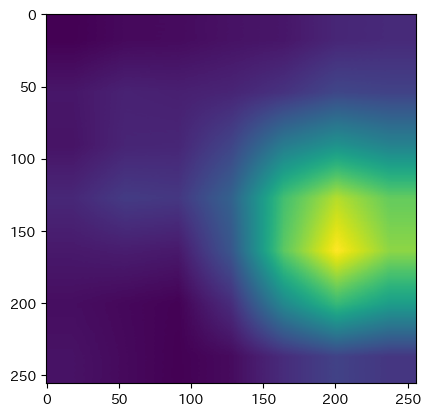

In [ ]:
idx[:10]
for _idx in idx[:10]:
    print(_idx, class_list[_idx], labelmeta[class_list[_idx]])


CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])
plt.imshow(CAMs[0])

In [ ]:
# 予測結果の出力
top_n = 10
print('認識結果')
for i in range(0, top_n):
    print(f'順位{i:2d} {class_list[idx[i]]}, {labelmeta[class_list[idx[i]]]} 確率:{probs[i]:.3f}')
    #print(f'順位{i:2d} {classes_ja[idx[i]]} 確率:{probs[i]:.3f}')

認識結果
順位 0 n03792782, ['mountain bike', 'all-terrain bike', 'off-roader'] 確率:0.565
順位 1 n02835271, ['bicycle-built-for-two', 'tandem bicycle', 'tandem'] 確率:0.116
順位 2 n09193705, ['alp'] 確率:0.098
順位 3 n04509417, ['unicycle', 'monocycle'] 確率:0.096
順位 4 n09332890, ['lakeside', 'lakeshore'] 確率:0.030
順位 5 n09428293, ['seashore', 'coast', 'seacoast', 'sea-coast'] 確率:0.014
順位 6 n09421951, ['sandbar', 'sand bar'] 確率:0.013
順位 7 n03733281, ['maze', 'labyrinth'] 確率:0.008
順位 8 n09246464, ['cliff', 'drop', 'drop-off'] 確率:0.008
順位 9 n04604644, ['worm fence', 'snake fence', 'snake-rail fence', 'Virginia fence'] 確率:0.006


CAM の出力  0:n03792782


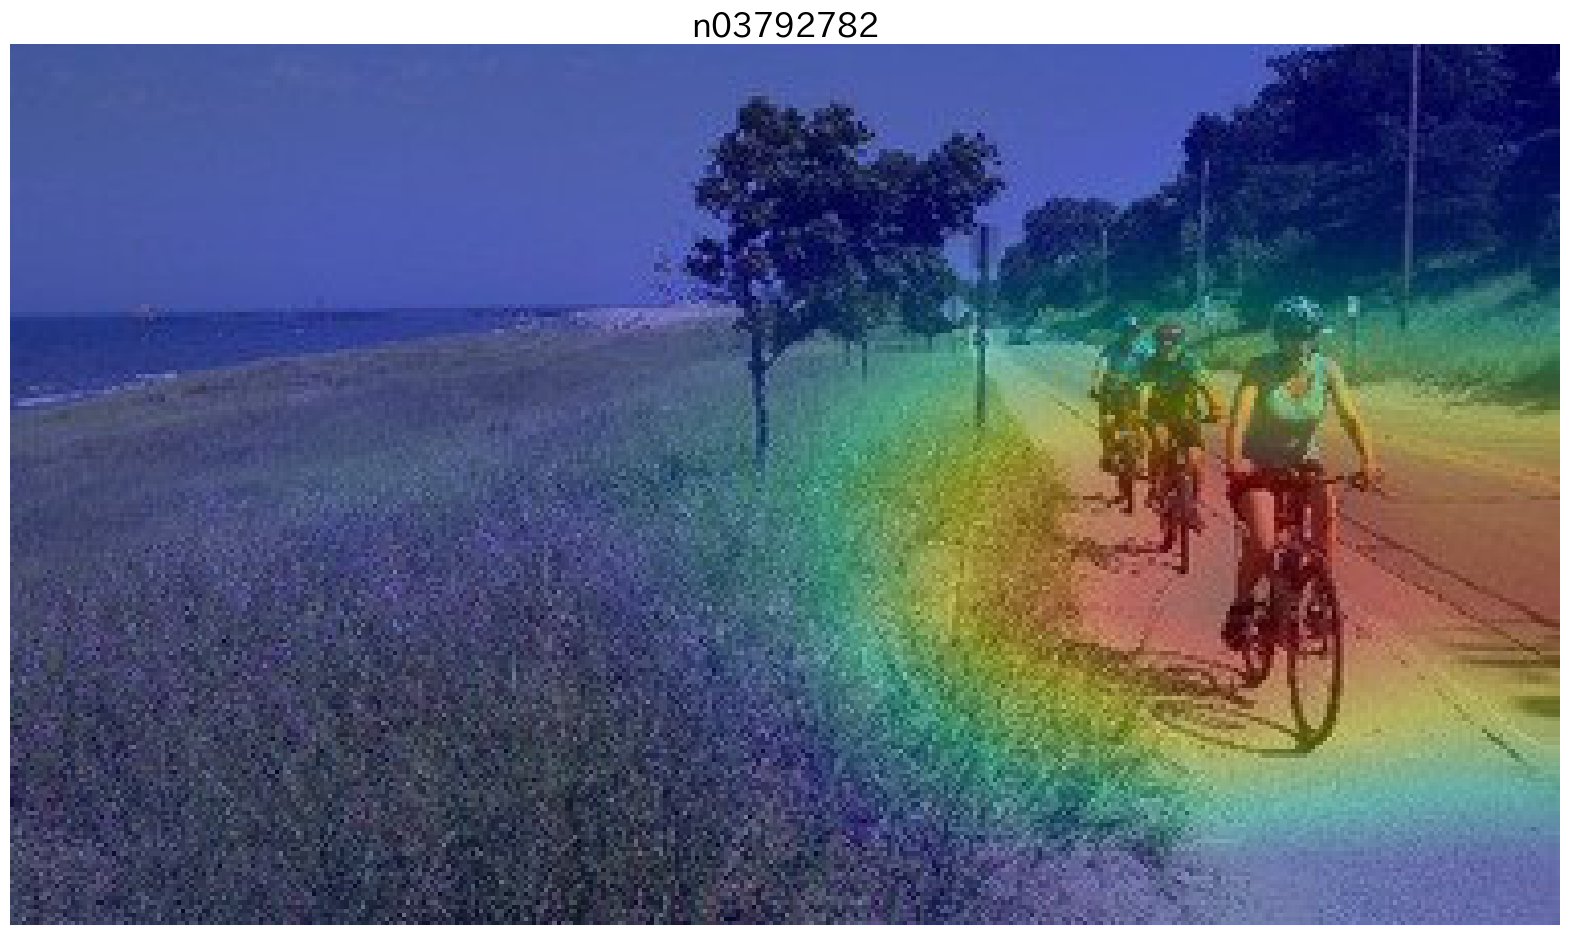

In [ ]:
# トップ 1 に認識されたカテゴリの活性値を元にヒートマップを描画
candidate = 0  # 順位 topn=0
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[candidate]])

# render the CAM and output
print(f'CAM の出力 {candidate:2d}:{class_list[idx[candidate]]}')
#print(f'CAM の出力 {candidate:2d}:{classes_ja[idx[candidate]]}')

img = cv2.imread('test.jpg')  # 元画像の読み込み
height, width, _ = img.shape  # 元画像の縦横サイズを取得
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)
#IPython.display.Image('CAM.jpg')
img_ = plt.imread('CAM.jpg')
plt.figure(figsize=(20,20))
plt.title(class_list[idx[candidate]], fontsize=24)
#plt.title(classes_ja[idx[candidate]], fontsize=24)
plt.axis('off'); plt.imshow(img_)

CAM の出力  0: n03792782
CAM の出力  1: n02835271


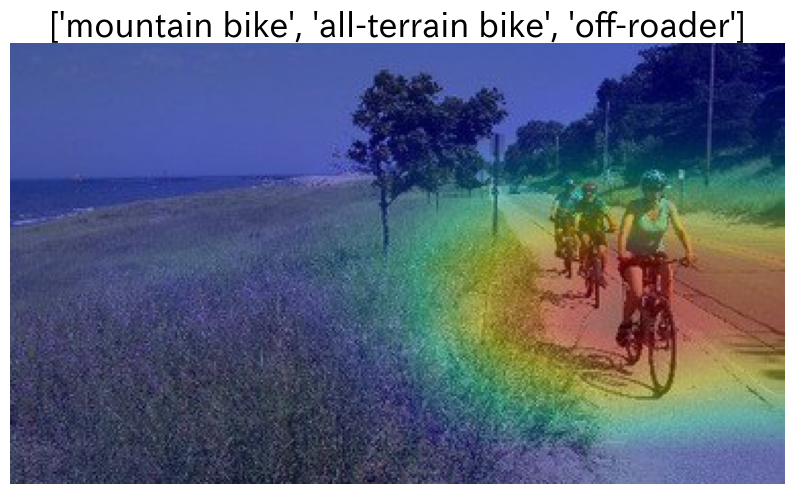

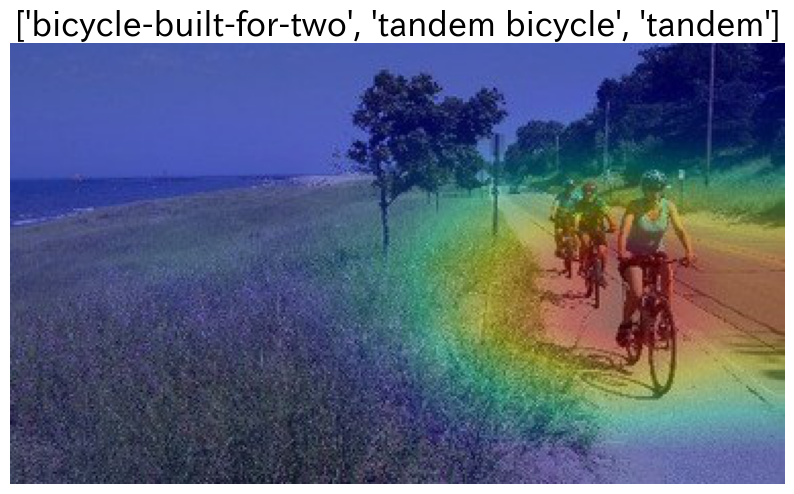

In [ ]:
height, width, _ = img.shape  # 元画像のサイズ

# top_n までの認識結果を表示
top_n = 2
for i in range(top_n):
    CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[i]])
    print(f'CAM の出力 {i:2d}: {class_list[idx[i]]}')
    #print(f'CAM の出力 {i:2d}: {classes_ja[idx[i]]}')

    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    img = cv2.imread('test.jpg')
    result = heatmap * 0.3 + img * 0.5
    out_fname = 'CAM'+str(i)+'.jpg'
    #cv2.imwrite('CAM.jpg', result)
    cv2.imwrite(out_fname,  result)
    #IPython.display.Image('CAM.jpg')
    plt.figure(figsize=(10,10))
    plt.title(labelmeta[class_list[idx[i]]], fontsize=24); plt.axis(False)
    #plt.title(classes_ja[idx[i]], fontsize=24); plt.axis(False)
    plt.imshow(pil_img.open(out_fname))
    #plt.imshow(pil_img.open('CAM.jpg'))
    #plt.show()

In [ ]:
# まとめて関数化
def CAM5(img_url, n=5):
    response = requests.get(img_url)
    img_pil = Image.open(io.BytesIO(response.content))
    img_pil.save('test.jpg')

    img_tensor = preprocess(img_pil)
    img_variable = Variable(img_tensor.unsqueeze(0))
    logit = net(img_variable)

    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()

    for cand in range(n):
        # generate class activation mapping for the top1 prediction
        CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[cand]])

        # render the CAM and output
        print(f'CAM の出力 {candidate}: {class_list[idx[cand]]} 確率:{probs[cand]:.3f}')
        #print(f'CAM の出力 {candidate}: {classes_ja[idx[cand]]} 確率:{probs[cand]:.3f}')

        img = cv2.imread('test.jpg')
        height, width, _ = img.shape
        heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + img * 0.5
        cv2.imwrite('CAM.jpg', result)
        #IPython.display.Image('CAM.jpg')
        plt.figure(figsize=(8,8))
        plt.axis(False)
        #plt.title(classes_ja[idx[cand]], fontsize=24)
        plt.title(labelmeta[class_list[idx[i]]], fontsize=24)
        plt.imshow(pil_img.open('CAM.jpg')); plt.show()


In [ ]:
# テスト実行
url_img = 'https://raw.githubusercontent.com/komazawa-deep-learning/komazawa-deep-learning.github.io/master/assets/2012AlexNetResult.jpg'
CAM5(url_img)